In [1]:
# load autoreload extension
%load_ext autoreload
%autoreload 2

In [2]:
overwrite_model=False
restore_model=False
train_model=True

In [3]:
import os
os.environ['JAX_PLATFORMS']="cpu"
# os.environ['JAX_PLATFORMS']="cuda"


import sys
sys.path.append("./src")

from flax import nnx
import jax 
import jax.numpy as jnp
import optax
import numpy as np

# visualization
import matplotlib.pyplot as plt

from matplotlib import cm

import time
import diffrax

In [4]:
import orbax.checkpoint as ocp
checkpoint_dir = "/lhome/ific/a/aamerio/github/cfm-jax/checkpoints/sbi_test_discrete"
os.makedirs(checkpoint_dir, exist_ok=True)

if overwrite_model:
    checkpoint_dir = ocp.test_utils.erase_and_create_empty(checkpoint_dir)

In [30]:
import jax
from jax import Array
import jax.numpy as jnp
from jax import random
from functools import partial

In [31]:
@partial(jax.jit, static_argnums=[1, 2])
def inf_train_gen(key: jax.random.PRNGKey, n_grid_points: int = 128, batch_size: int = 200) -> Array:
    assert n_grid_points % 4 == 0, "number of grid points has to be divisible by 4"
    
    n_grid_points = n_grid_points // 4
    
    key1, key2, key3 = jax.random.split(key, 3)
    
    x1 = jax.random.randint(key1, shape=(batch_size,), minval=0, maxval=n_grid_points * 4)
    samples_x2 = jax.random.randint(key2, shape=(batch_size,), minval=0, maxval=n_grid_points)
    
    x2 = (
        samples_x2
        + 2 * n_grid_points
        - jax.random.randint(key3, shape=(batch_size,), minval=0, maxval=2) * 2 * n_grid_points
        + (jnp.floor(x1 / n_grid_points) % 2) * n_grid_points
    )
    
    x_end = 1.0 * jnp.concatenate([x1[:, None], x2[:, None]], axis=1)

    return x_end.astype(jnp.int32)

In [33]:
samples

Array([[ 47,  46],
       [  9,  70],
       [ 31,   8],
       ...,
       [112, 106],
       [ 45, 123],
       [104, 116]], dtype=int32)

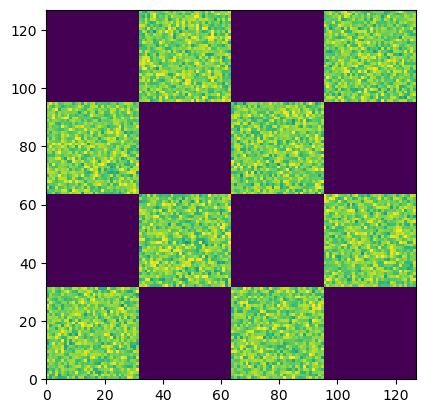

In [36]:
samples = inf_train_gen(jax.random.PRNGKey(0), 128, 500_000)

H=plt.hist2d(samples[:,0], samples[:,1], bins=128)
cmin = 0.0
cmax = jnp.quantile(jnp.array(H[0]), 0.99).item()
norm = cm.colors.Normalize(vmax=cmax, vmin=cmin)

_ = plt.hist2d(samples[:,0], samples[:,1], bins=128, norm=norm)

# set equal ratio of axes
plt.gca().set_aspect('equal', adjustable='box')


plt.show()

In [37]:
from flow_matching.path import MixtureDiscreteProbPath
from flow_matching.path.scheduler import PolynomialConvexScheduler
from flow_matching.solver import MixtureDiscreteEulerSolver
from flow_matching.utils import ModelWrapper
from flow_matching.loss import MixturePathGeneralizedKL


In [38]:
from einops import rearrange

In [71]:
class MLP(nnx.Module):
    def __init__(self, input_dim, hidden_dim: int = 128, time_dim=1, length=2, *, rngs: nnx.Rngs):

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        self.time_embedding = nnx.Linear(1, time_dim, rngs=rngs)
        self.token_embedding = nnx.Embed(self.input_dim, hidden_dim, rngs=rngs)

        self.linear1 = nnx.Linear(self.hidden_dim*length + time_dim, self.hidden_dim, rngs=rngs)
        self.linear2 = nnx.Linear(self.hidden_dim, self.hidden_dim, rngs=rngs)
        self.linear3 = nnx.Linear(self.hidden_dim, self.hidden_dim, rngs=rngs)
        self.linear4 = nnx.Linear(self.hidden_dim, self.hidden_dim, rngs=rngs)
        self.linear5 = nnx.Linear(self.hidden_dim, self.input_dim*length, rngs=rngs)

    def __call__(self, x: jax.Array, t: jax.Array, args=None):
        x = jnp.atleast_2d(x)
        t = jnp.atleast_1d(t)
        if len(t.shape)<2:
            t = t[..., None]
            t = jnp.broadcast_to(t, (x.shape[0], t.shape[-1]))

        x = self.token_embedding(x)
        t = self.time_embedding(t)

        B, N, D = x.shape

        x = x.reshape(B, N * D)

        h = jnp.concatenate([x, t], axis=1)

        x = self.linear1(h)
        x = jax.nn.gelu(x)

        x = self.linear2(x)
        x = jax.nn.gelu(x)

        x = self.linear3(x)
        x = jax.nn.gelu(x)

        x = self.linear4(x)
        x = jax.nn.gelu(x)

        x = self.linear5(x)

        x = x.reshape(B, N, self.input_dim)

        return x

In [72]:
# training arguments
lr = 0.001
iterations = 20001
print_every = 2000
hidden_dim = 128
vocab_size = 128
epsilon = 1e-3

source_distribution = "uniform"

In [73]:
# restore the model
# if restore_model:
#     model_state = nnx.state(vf_model)

#     with ocp.CheckpointManager(
#         checkpoint_dir, options=ocp.CheckpointManagerOptions(read_only=True)
#     ) as read_mgr:
#         restored = read_mgr.restore(
#             1,
#             # pass in the model_state to restore the exact same State type
#             args=ocp.args.Composite(state=ocp.args.PyTreeRestore(item=model_state))
#         )


#     abstract_model = MLP(input_dim=2, hidden_dim=hidden_dim, rngs=nnx.Rngs(0))
#     graphdef, abstract_state = nnx.split(abstract_model)

#     vf_model= nnx.merge(graphdef, restored["state"])

In [74]:
batch_size = 4096

In [75]:
if source_distribution == "uniform":
    added_token = 0
elif source_distribution == "mask":
    mask_token = vocab_size  # tokens starting from zero
    added_token = 1
else:
    raise NotImplementedError
    
# additional mask token
vocab_size += added_token

# probability denoiser model init
probability_denoiser = MLP(input_dim=vocab_size, time_dim=1, hidden_dim=hidden_dim, rngs=nnx.Rngs(0))

# init optimizer
optimizer = nnx.Optimizer(probability_denoiser, optax.adamw(lr))

In [76]:
# instantiate an affine path object
scheduler = PolynomialConvexScheduler(n=2.0)
path = MixtureDiscreteProbPath(scheduler=scheduler)

loss_fn_ = MixturePathGeneralizedKL(path=path)

def loss_fn(probability_denoiser, batch, key):
    t, x_0, x_1 = batch
    path_sample = path.sample(t=t, x_0=x_0, x_1=x_1, key=key)
    logits = probability_denoiser(x=path_sample.x_t, t=path_sample.t)
    loss = loss_fn_(logits=logits, x_1=x_1, x_t=path_sample.x_t, t=path_sample.t)
    return loss


@nnx.jit
def train_step(probability_denoiser, optimizer, batch, key):
    # sample data (user's responsibility): in this case, (X_0,X_1) ~ pi(X_0,X_1) = N(X_0|0,I)q(X_1)
    grad_fn = nnx.value_and_grad(loss_fn)
    loss, grads = grad_fn(probability_denoiser, batch, key)
    optimizer.update(grads)  # In-place updates.

    return loss

In [77]:
if train_model:
    probability_denoiser.train()

    start_time = time.time()
    key = jax.random.PRNGKey(0)
    for i in range(iterations):
        key, subkey1, subkey2, subkey3, subkey4 = jax.random.split(key, 5)
        x_1 = inf_train_gen(subkey1, batch_size=batch_size) # sample data

        if source_distribution == "uniform":
            x_0 = jax.random.randint(subkey2, x_1.shape, 0, vocab_size)
        elif source_distribution == "mask":
            x_0 = jnp.zeros_like(x_1) + mask_token
        else:
            raise NotImplementedError

        t = jax.random.uniform(subkey3, x_1.shape[0], maxval=1-epsilon)

        batch = (t, x_0, x_1)
        loss = train_step(probability_denoiser, optimizer, batch, subkey4)

        # log loss
        if (i+1) % print_every == 0:
            elapsed = time.time() - start_time
            print('| iter {:6d} | {:5.2f} ms/step | loss {:8.3f} '
                .format(i+1, elapsed*1000/print_every, loss.item()))
            start_time = time.time()

    probability_denoiser.eval()

| iter   2000 | 35.76 ms/step | loss    5.580 
| iter   4000 | 35.82 ms/step | loss    5.505 
| iter   6000 | 35.86 ms/step | loss    6.005 
| iter   8000 | 35.69 ms/step | loss    5.905 
| iter  10000 | 35.51 ms/step | loss    5.711 
| iter  12000 | 35.47 ms/step | loss    5.939 
| iter  14000 | 35.74 ms/step | loss    5.597 
| iter  16000 | 35.56 ms/step | loss    5.430 
| iter  18000 | 35.72 ms/step | loss    5.457 
| iter  20000 | 35.79 ms/step | loss    5.634 


In [ ]:
# save the model
if train_model:
    checkpoint_manager = ocp.CheckpointManager(checkpoint_dir,
        options=ocp.CheckpointManagerOptions(
            max_to_keep=2,
            keep_checkpoints_without_metrics=False,
            create=True,
        ),
    )
    model_state = nnx.state(probability_denoiser)
    checkpoint_manager.save(
        1, args=ocp.args.Composite(state=ocp.args.PyTreeSave(model_state))
    )

    checkpoint_manager.close()

# sample the model

In [78]:
probability_denoiser.eval()

In [94]:
class MW(ModelWrapper):
    def __call__(self, x, t, **extras):
        return jax.nn.softmax(self.model(x, t), axis=-1)

In [95]:
pd_wrapped = MW(probability_denoiser)
solver = MixtureDiscreteEulerSolver(model=pd_wrapped, path=path, vocabulary_size=vocab_size)

In [102]:
nfe = 64
step_size = 1 / nfe

key = jax.random.PRNGKey(0)

safe_sampling = True
n_samples = 100_000
dim = 2

if source_distribution == "uniform":
    x_init = jax.random.randint(key, shape=(n_samples, dim), minval=0, maxval=vocab_size)
elif source_distribution == "mask":
    x_init = (jnp.zeros((n_samples, dim)) + mask_token).astype(jnp.int32)
else:
    raise NotImplementedError

n_plots = 9
linspace_to_plot = jnp.linspace(0,  1 - epsilon, n_plots)

sol = solver.sample(key, x_init=x_init, 
                    step_size=step_size, 
                    verbose=True, 
                    return_intermediates=True,
                    time_grid=linspace_to_plot)

NFE: 0:   0%|          | 0/0.9990000128746033 [07:50<?, ?it/s]
NFE: 0:   0%|          | 0/0.9990000128746033 [04:50<?, ?it/s]
NFE: 0:   0%|          | 0/0.9990000128746033 [04:42<?, ?it/s]
NFE: 9:  14%|█▍        | 0.140625/0.9990000128746033 [04:24<26:55, 1882.59s/it]
NFE: 64: 100%|██████████| 0.9990000128746033/0.9990000128746033 [02:19<00:00, 139.45s/it]


In [104]:
sol

array([[[101,  80],
        [ 72,  61],
        [  3,  83],
        ...,
        [  0,  61],
        [ 92,  73],
        [ 63, 110]],

       [[101,  80],
        [ 72,  61],
        [  3,  83],
        ...,
        [  0,  61],
        [ 92,  73],
        [ 63,  50]],

       [[101,  80],
        [ 72,  61],
        [  3,  83],
        ...,
        [  0,  61],
        [ 92,  73],
        [ 63,  50]],

       ...,

       [[ 15,  76],
        [ 72,  73],
        [124,  91],
        ...,
        [  0,  61],
        [ 38, 108],
        [ 63,  50]],

       [[ 15,  11],
        [ 72,  73],
        [ 17,  13],
        ...,
        [  0,  61],
        [ 47,  76],
        [ 63,  50]],

       [[ 35,  31],
        [ 91,  57],
        [123,  85],
        ...,
        [ 70,  88],
        [ 36,  51],
        [ 38,   5]]], shape=(9, 100000, 2), dtype=int32)

In [106]:
sol.shape

(9, 100000, 2)

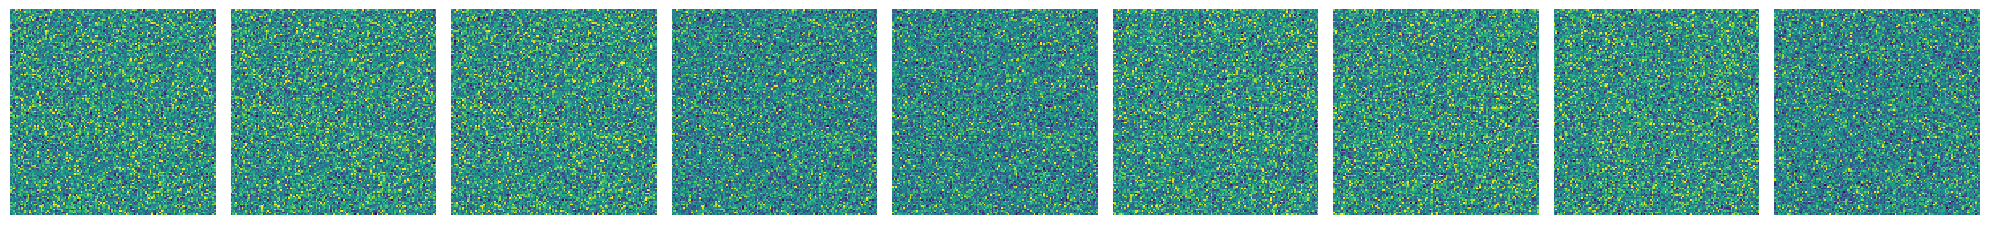

In [108]:
sol = np.array(sol)  # convert to numpy array
# T = np.array(T)  # convert to numpy array

fig, axs = plt.subplots(1, 9, figsize=(20,20))

for i in range(9):
    H = axs[i].hist2d(sol[i,:,0], sol[i,:,1], bins=vocab_size)
    
    cmin = 0.0
    cmax = jnp.quantile(jnp.array(H[0]), 0.99).item()
    
    norm = cm.colors.Normalize(vmax=cmax, vmin=cmin)
    
    _ = axs[i].hist2d(sol[i,:,0], sol[i,:,1], bins=vocab_size, norm=norm)
    
    axs[i].set_aspect('equal')
    axs[i].axis('off')
    # axs[i].set_title('t= %.2f' % (T[i]))
    
plt.tight_layout()
plt.show()

# sample the likelihood

In [23]:
import numpyro.distributions as dist

In [24]:
# sample with likelihood

T = jnp.array([1., 0.])  # sample times
grid_size = 200
x_1 = jnp.meshgrid(jnp.linspace(-5, 5, grid_size), jnp.linspace(-5, 5, grid_size))
x_1 = jnp.stack([x_1[0].flatten(), x_1[1].flatten()], axis=1)

In [3]:
import diffrax

In [12]:

# diffrax.Euler
# get the function name of the solver
solver_name = diffrax.Euler.__name__
solver_name

'Euler'

In [15]:
diffrax.Euler.*?

diffrax.Euler.__abstractclassvars__
diffrax.Euler.__abstractmethods__
diffrax.Euler.__abstractvars__
diffrax.Euler.__annotations__
diffrax.Euler.__base__
diffrax.Euler.__bases__
diffrax.Euler.__basicsize__
diffrax.Euler.__call__
diffrax.Euler.__class__
diffrax.Euler.__class_getitem__
diffrax.Euler.__dataclass_fields__
diffrax.Euler.__dataclass_params__
diffrax.Euler.__delattr__
diffrax.Euler.__dict__
diffrax.Euler.__dictoffset__
diffrax.Euler.__dir__
diffrax.Euler.__doc__
diffrax.Euler.__eq__
diffrax.Euler.__flags__
diffrax.Euler.__format__
diffrax.Euler.__ge__
diffrax.Euler.__getattribute__
diffrax.Euler.__getstate__
diffrax.Euler.__gt__
diffrax.Euler.__hash__
diffrax.Euler.__init__
diffrax.Euler.__init_subclass__
diffrax.Euler.__instancecheck__
diffrax.Euler.__itemsize__
diffrax.Euler.__le__
diffrax.Euler.__lt__
diffrax.Euler.__match_args__
diffrax.Euler.__module__
diffrax.Euler.__mro__
diffrax.Euler.__name__
diffrax.Euler.__ne__
diffrax.Euler.__new__
diffrax.Euler.__or__
diffrax.Eul

In [25]:
# source distribution is an isotropic gaussian
gaussian_log_density = dist.Independent(dist.Normal(jnp.zeros(2), jnp.ones(2)), 1).log_prob

In [ ]:
sampler = solver.get_unnormalized_logprob(time_grid=[1.0,0.0], method='Dopri5', step_size=step_size, log_p0=gaussian_log_density)

_, exact_log_p = sampler(x_1)

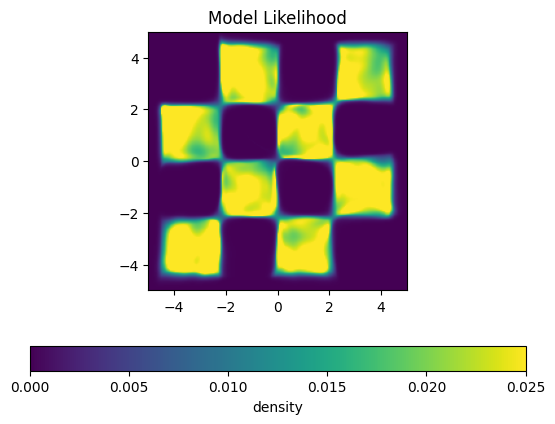

In [27]:
likelihood = np.array(jnp.exp(exact_log_p[-1,:]).reshape(grid_size, grid_size))


# cmin = 0.0
# cmax = 1/32 # 1/32 is the gt likelihood value
cmin = 0 
cmax = 1/40

norm = cm.colors.Normalize(vmax=cmax, vmin=cmin)

# Create the figure and axis objects explicitly
fig, ax = plt.subplots()

likelihood = np.array(jnp.exp(exact_log_p[-1,:]).reshape(grid_size, grid_size))

norm = cm.colors.Normalize(vmax=cmax, vmin=cmin)

im = ax.imshow(likelihood, extent=(-5, 5, -5, 5), origin='lower', cmap='viridis', norm=norm)
# im = ax.imshow(likelihood, extent=(-5, 5, -5, 5), origin='lower', cmap='viridis')
ax.set_title('Model Likelihood')

# plt.scatter(sol[0,:,0], sol[0,:,1], color="red", s=1, alpha=0.5)
# plt.plot(sol[:,:,0], sol[:,:,1], color="white", lw=0.2, alpha=0.7)
# plt.scatter(sol[-1,:,0], sol[-1,:,1], color="blue", s=2, alpha=1, zorder=2)
# plt.gca().set_aspect('equal', adjustable='box')
# plt.show()

# Use the current figure/axis for the colorbar
plt.colorbar(im, ax=ax, orientation='horizontal', label='density')
plt.show()